In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import math

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device=",device)
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device= cuda


In [2]:
class vggNet(torch.nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        super(vggNet,self).__init__()
        self.conv_layers = nn.Sequential(

            nn.Conv2d(self.in_channels,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
           
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512,out_features=4096),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(4096,self.num_classes)

            )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer  = optim.SGD(self.parameters(),lr=0.001,momentum=0.9)
    def forward(self,x):
        x=self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    def do_train(self,train_data_loder,test_data_loder,num_epochs,batch_size,device):
        train_len = len(train_data_loder)*batch_size
        test_len = len(test_data_loder)*batch_size
        total_step = len(train_data_loder)*batch_size
        # Record loss
        train_loss = []
        test_loss =  []

        # Record accuracy
        train_accuracy  = []
        test_accuracy = []
        
        for epoch in range(num_epochs):
            # training the model 
            self.train()
            for i,(images,labels) in enumerate(train_data_loder):
                #move the input data to device
                images=images.to(device)
                labels=labels.to(device)
                #run the model on the input data
                outputs = model(images)
                # cal the loss
                loss = self.criterion(outputs,labels)
                # backprop
                self.optimizer.zero_grad()
                # do backprop
                loss.backward()
                # update the params
                self.optimizer.step() 
            #  evaluating the model to compute the training, testing  accuracy, and loss  at the current epoch
            self.eval()
            correct_predictions =0
            loss = 0
            with torch.no_grad():
                for data in train_data_loder:
                    #accuracy
                    images,true_labels = data
                    images,true_labels = images.to(device),true_labels.to(device)
                    nn_outputs=self(images).to(device)
                    _,predicted = torch.max(nn_outputs.data,1)
                    correct_predictions += (predicted == true_labels).sum().item()
                    #loss
                    loss += self.criterion(nn_outputs,true_labels).item()
            train_loss.append( loss / train_len )
            train_accuracy.append(correct_predictions / train_len )
            train_acc_i = correct_predictions / train_len 
            # For Test accuracy and test loss
            correct_predictions =0
            loss = 0
            with torch.no_grad():
                for data in test_data_loder:
                    #accuracy
                    images,true_labels = data
                    images,true_labels = images.to(device),true_labels.to(device)
                    nn_outputs=self(images).to(device)
                    _,predicted = torch.max(nn_outputs.data,1)
                    correct_predictions += (predicted == true_labels).sum().item()
                    #loss
                    loss += self.criterion(nn_outputs,true_labels).item()
            test_loss.append( loss / test_len )
            test_accuracy.append(correct_predictions / test_len )
            test_acc_i = correct_predictions / test_len 
            print(f'Epoch done [{epoch+1}], training-Acccuracy: {train_acc_i:.4f} , testing-accuracy:{test_acc_i }')
        print('Finished')
        return train_loss, train_accuracy, test_loss, test_accuracy
    def evaluate_(self,eval_datas,batch_size,device): 
        self.eval()
        correct_predictions =0
        loss = 0
        test_loss = []
        test_accuracy = []
        test_len = len(eval_datas)*batch_size
        with torch.no_grad():
            for data in eval_datas:
                #accuracy
                images,true_labels = data
                images,true_labels = images.to(device),true_labels.to(device)
                nn_outputs=self(images).to(device)
                _,predicted = torch.max(nn_outputs.data,1)
                correct_predictions += (predicted == true_labels).sum().item()
                #loss
                loss += self.criterion(nn_outputs,true_labels).item()
        test_loss.append( loss / test_len )
        test_accuracy.append(correct_predictions / test_len )
        test_acc_i = correct_predictions / test_len 
        return test_loss,test_accuracy

In [3]:
batchSize = 64
num_epochs = 5
training_tensor = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.RandomVerticalFlip(p=0.5),
                                 torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                 torchvision.transforms.RandomChoice([
                                     torchvision.transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x)),
                                     torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x)),
                                     torchvision.transforms.Lambda(lambda x : x + torch.randn_like(x))])
                             ])),
                            batch_size = batchSize,
                            shuffle = True)
testing_tensor = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.RandomVerticalFlip(p=0.5),
                                 torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                 torchvision.transforms.RandomChoice([
                                     torchvision.transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x)),
                                     torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x)),
                                     torchvision.transforms.Lambda(lambda x : x + torch.randn_like(x))])
                             ])),
                            batch_size = batchSize,
                            shuffle = True)

In [4]:
model = vggNet().to(device)
train_loss, train_accuracy, test_loss, test_accuracy=model.do_train(training_tensor, testing_tensor,num_epochs, batchSize, device)

Epoch done [1], training-Acccuracy: 0.8790 , testing-accuracy:0.8725119426751592
Epoch done [2], training-Acccuracy: 0.8835 , testing-accuracy:0.8764928343949044
Epoch done [3], training-Acccuracy: 0.9417 , testing-accuracy:0.9376990445859873
Epoch done [4], training-Acccuracy: 0.9454 , testing-accuracy:0.9381966560509554
Epoch done [5], training-Acccuracy: 0.9537 , testing-accuracy:0.9470541401273885
Finished


In [5]:
PATH = './model_4'
torch.save(model, PATH)

In [6]:
batchSize=1
testloader_horiflip = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.RandomHorizontalFlip(p=1)
                             ])),
                            batch_size = batchSize
                                )
testloader_vertiflip = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.RandomVerticalFlip(p=1)
                             ])),
                            batch_size = batchSize)

testloader_gaussian_001 = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))
                             ])),
                            batch_size = batchSize)
testloader_gaussian_01 = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))
                             ])),
                            batch_size = batchSize)
testloader_gaussian_1 = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081),
                                 torchvision.transforms.Lambda(lambda x : x + 1*torch.randn_like(x))
                             ])),
                            batch_size = batchSize)

In [7]:
PATH = './model_4'
loaded_model = torch.load(PATH, map_location=torch.device(device))
batchSize=1

horizontal_flip_aug = (loaded_model.evaluate_(testloader_horiflip, batchSize,device)[1][0] * 100)
vertical_flip_aug = (loaded_model.evaluate_( testloader_vertiflip, batchSize,device)[1][0] * 100)
gaussian_001_aug = (loaded_model.evaluate_( testloader_gaussian_001, batchSize,device)[1][0] * 100)
gaussian_01_aug = (loaded_model.evaluate_( testloader_gaussian_01, batchSize,device)[1][0] * 100)
gaussian_1_aug = (loaded_model.evaluate_(testloader_gaussian_1, batchSize,device)[1][0] * 100)

print('The accuracy for horizontal flip is %.2f%%' % horizontal_flip_aug)
print('The accuracy for Vertical flip is %.2f%%' % vertical_flip_aug)
print('The accuracy for Random Gaussian Noise 0.01 is %.2f%%' % gaussian_001_aug)
print('The accuracy for Random Gaussian Noise 0.1 is %.2f%%' % gaussian_01_aug)
print('The accuracy for Random Gaussian Noise 1 is %.2f%%' % gaussian_1_aug)

The accuracy for horizontal flip is 95.71%
The accuracy for Vertical flip is 95.55%
The accuracy for Random Gaussian Noise 0.01 is 95.72%
The accuracy for Random Gaussian Noise 0.1 is 95.63%
The accuracy for Random Gaussian Noise 1 is 93.28%


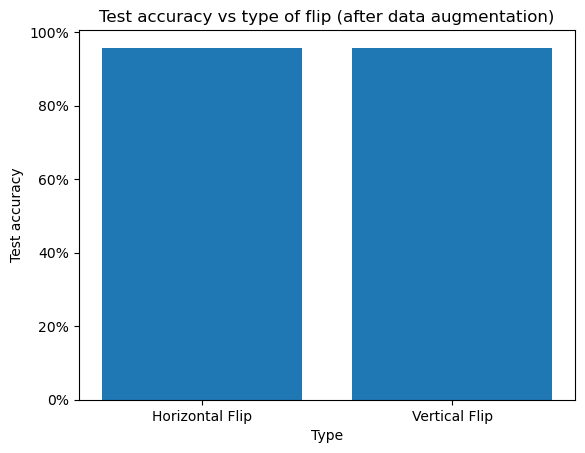

In [8]:
plt.bar(["Horizontal Flip", "Vertical Flip"],[horizontal_flip_aug, vertical_flip_aug])
plt.title('Test accuracy vs type of flip (after data augmentation)')
plt.xlabel('Type')
plt.ylabel('Test accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('E2Q4_a')

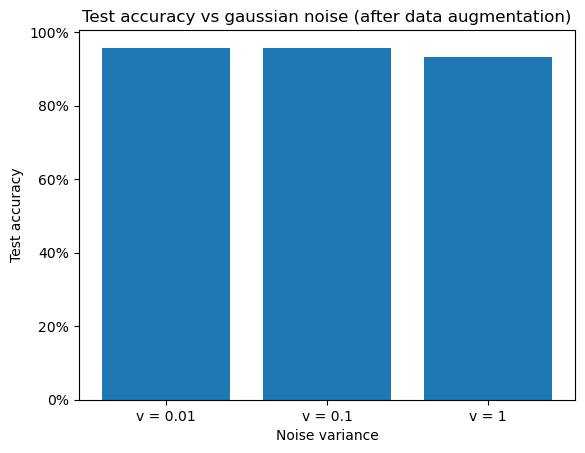

In [9]:
plt.bar(["v = 0.01", "v = 0.1", "v = 1"],[gaussian_001_aug, gaussian_01_aug, gaussian_1_aug])
plt.title('Test accuracy vs gaussian noise (after data augmentation)')
plt.xlabel('Noise variance')
plt.ylabel('Test accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('E2Q4_b')